# Stellar Migration

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

In [2]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.settings import Settings
from auriga.support import find_indices

In [51]:
figure_setup()

In [4]:
settings = Settings()

## Calculate Stellar Migration

In [5]:
def read_data(simulation: str) -> pd.DataFrame:
    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.tag_in_situ_stars()
    s.tag_particles_by_region(
        disc_std_circ=settings.disc_std_circ,
        disc_min_circ=settings.disc_min_circ,
        cold_disc_delta_circ=settings.cold_disc_delta_circ,
        bulge_max_specific_energy=settings.bulge_max_specific_energy)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)
    is_in_situ = (s.is_in_situ == 1)
    is_target = is_real_star & is_main_obj & is_in_situ

    props = {
        "ID": s.ids[is_target],
        "ComponentTag": s.region_tag[is_target],
        "FormationSnapshot": s.stellar_formation_snapshot[is_target],
        }

    return pd.DataFrame(props)

In [6]:
def read_reduced_data(simulation: str) -> pd.DataFrame:
    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.tag_particles_by_region(
        disc_std_circ=settings.disc_std_circ,
        disc_min_circ=settings.disc_min_circ,
        cold_disc_delta_circ=settings.cold_disc_delta_circ,
        bulge_max_specific_energy=settings.bulge_max_specific_energy)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)
    is_target = is_real_star & is_main_obj

    props = {
        "ID": s.ids[is_target],
        "ComponentTag": s.region_tag[is_target],
        }

    return pd.DataFrame(props)

In [44]:
with open("../results/stellar_migration.json") as f:
       migration_matrices = json.load(f)

for galaxy in tqdm(settings.galaxies):
    SIMULATION = f"au{galaxy}_or_l4"
    df = read_data(f"{SIMULATION}_s127")

    # Find component tag at birth
    component_at_birth = -1 * np.ones(len(df), dtype=np.int8)
    for i in range(40, 127, 1):
        this_df = read_reduced_data(f"{SIMULATION}_s{i}")

        idx = find_indices(
            this_df["ID"].to_numpy(),
            df["ID"][df["FormationSnapshot"] == i].to_numpy(),
            -1)

        component_at_birth[df["FormationSnapshot"] == i] \
            = this_df["ComponentTag"][idx].to_numpy()

    # Add component tags at birth for the last snapshot
    component_at_birth[df["FormationSnapshot"] == 127] \
            = df["ComponentTag"][df["FormationSnapshot"] == 127].to_numpy()

    df["ComponentTagAtBirth"] = component_at_birth

    migration_matrix = np.zeros((4, 4))
    for i in range(0, 4):
        n_particles = (df["ComponentTag"] == i).sum()
        for j in range(0, 4):
            migration_matrix[i, j] = (
                (df["ComponentTag"] == i) \
                    & (df["ComponentTagAtBirth"] == j)).sum() \
                        / n_particles * 100
    
    migration_matrices[SIMULATION] = list(migration_matrix.flatten())

    with open("../results/stellar_migration.json", "w") as f:
        json.dump(migration_matrices, f)

## Results

In [48]:
# Read data
with open("../results/stellar_migration.json", 'r') as f:
    migration_matrices = json.load(f)
migration_matrix = np.array(migration_matrices[SIMULATION]).reshape(4, 4)

### Plot Galaxy

In [45]:
SIMULATION = "au6_or_l4"

In [49]:
migration_matrix

array([[30.11286494,  5.75153055, 34.83736621, 29.06084711],
       [ 4.09007447, 36.53968232, 30.39637955, 28.50219452],
       [ 0.72921942,  1.19210856, 89.01119786,  9.05063719],
       [ 3.540623  ,  5.57112103, 64.1238117 , 26.68621446]])

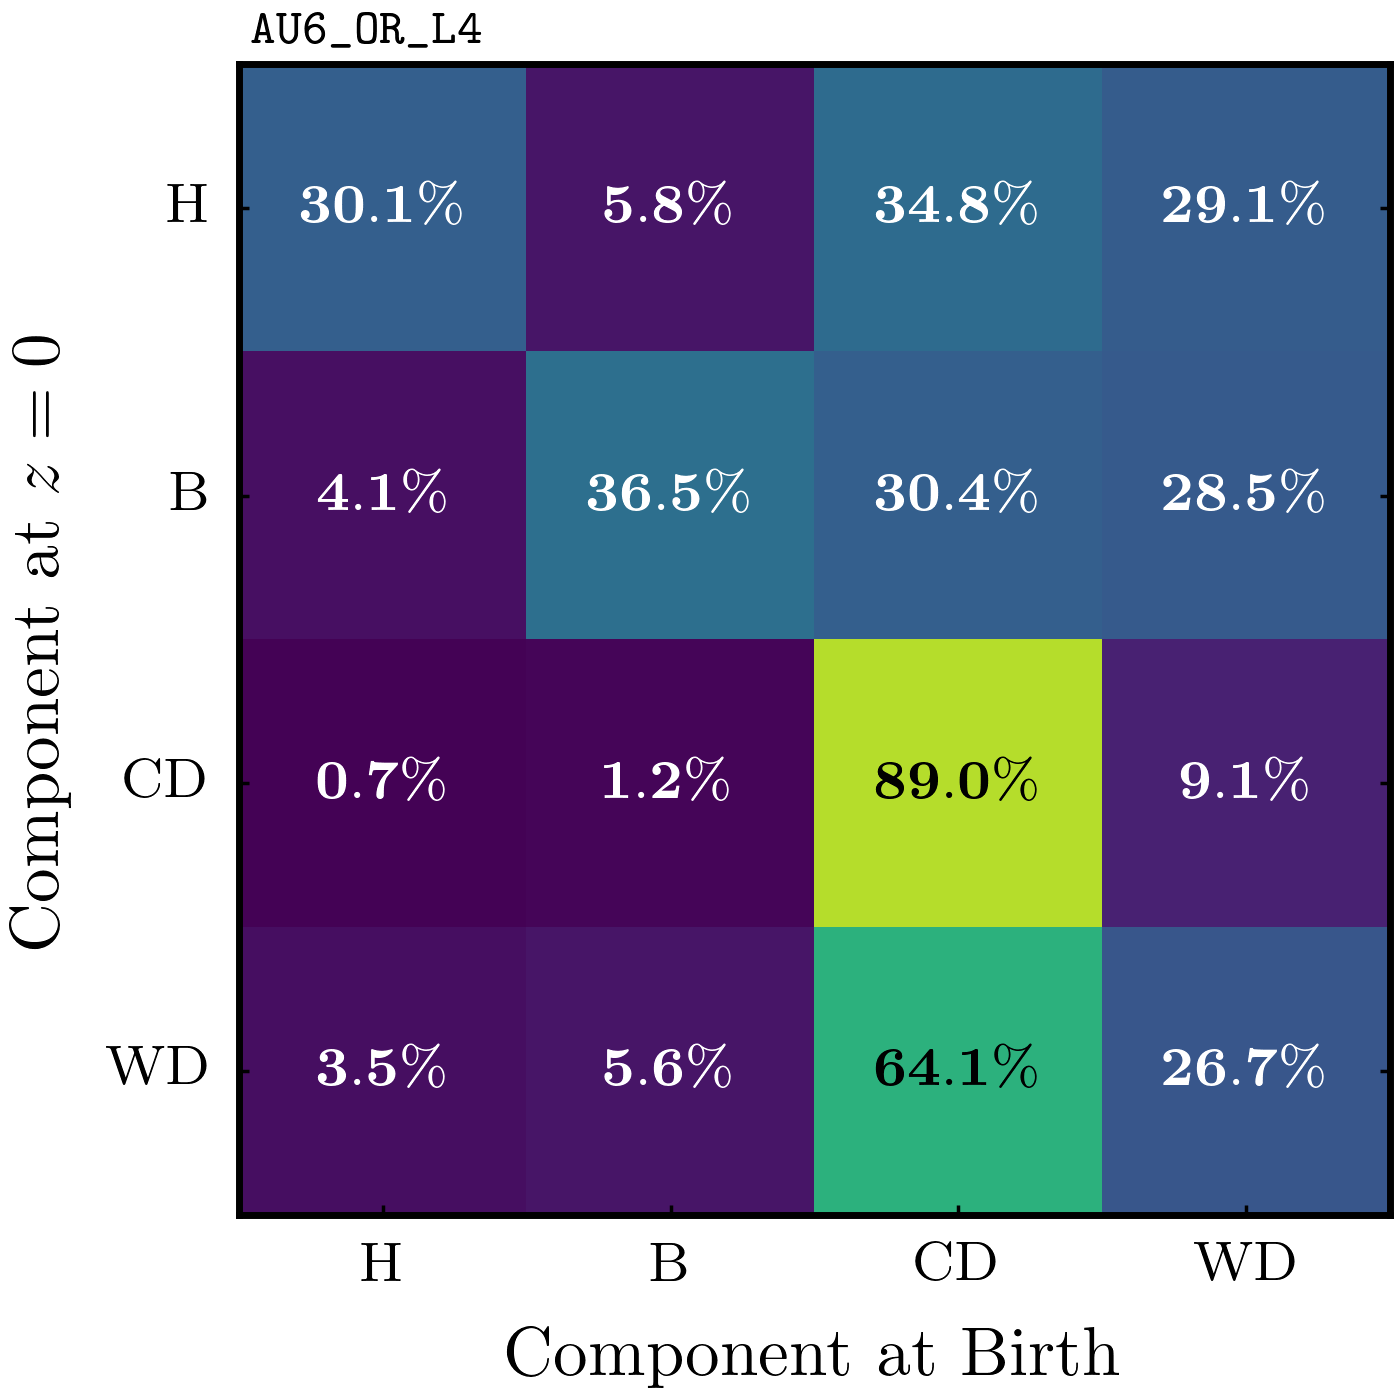

In [52]:
fig = plt.figure(figsize=(3.0, 3.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=False)

ax.matshow(migration_matrix, cmap="viridis", vmin=0, vmax=100)

ax.set_xlabel(r"Component at Birth")
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(settings.components)
ax.tick_params(axis='x', bottom=True, top=False,
               labelbottom=True, labeltop=False)

ax.set_ylabel(r"Component at $z=0$")
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(settings.components)

for i in range(migration_matrix.shape[0]):
    for j in range(migration_matrix.shape[1]):
        color = "white" if migration_matrix[j, i] < 50 else "black"
        ax.text(
            i, j,
            r"$\mathbf{" + f"{np.round(migration_matrix[j, i], 1)}" + r"\%}$",
            c=color, ha="center", va="center")

ax.text(x=0.01, y=1.01, size=7.0,
        s=r"$\texttt{" + f"{SIMULATION}".upper() + "}$",
        ha="left", va="bottom", transform=ax.transAxes)

fig.tight_layout()
plt.show()